# load data

In [2]:
import dask.dataframe as dd
import os

input_file = '/Users/hungwei/Desktop/Proj/AI_DDOS/final_dataset.csv'  # 修正檔案名稱
output_file = '/Users/hungwei/Desktop/Proj/AI_DDOS/processed_output.csv'  # 輸出檔案路徑

# 檢查輸入檔案是否存在
if not os.path.exists(input_file):
    raise FileNotFoundError(f"檔案 {input_file} 不存在，請確認檔案路徑或名稱是否正確！")

# 使用 dask 讀取 CSV 的前 100 行
df_head = dd.read_csv(input_file, assume_missing=True).head(100)
print(df_head)
df = dd.from_pandas(df_head, npartitions=1) # Convert back to a Dask DataFrame with one partition

print(f"成功讀取前 {len(df)} 行資料。")
print(f"Dask DataFrame 的 partitions 數量: {df.npartitions}")

# 你可以繼續對 df 這個 Dask DataFrame 進行後續的處理
# 例如：
# df.to_csv(output_file, single_file=True, index=False)

    Unnamed: 0                               Flow ID         Src IP  Src Port  \
0        624.0  192.168.4.118-203.73.24.75-4504-80-6  192.168.4.118    4504.0   
1        625.0  192.168.4.118-203.73.24.75-4504-80-6  192.168.4.118    4504.0   
2        626.0  192.168.4.118-203.73.24.75-4505-80-6  192.168.4.118    4505.0   
3        627.0  192.168.4.118-203.73.24.75-4505-80-6  192.168.4.118    4505.0   
4        628.0  192.168.4.118-203.73.24.75-4506-80-6  192.168.4.118    4506.0   
..         ...                                   ...            ...       ...   
95       917.0  192.168.4.118-203.73.24.75-4551-80-6  192.168.4.118    4551.0   
96       919.0  192.168.4.118-203.73.24.75-4552-80-6  192.168.4.118    4552.0   
97       920.0  192.168.4.118-203.73.24.75-4552-80-6  192.168.4.118    4552.0   
98       921.0  192.168.4.118-203.73.24.75-4553-80-6  192.168.4.118    4553.0   
99       922.0  192.168.4.118-203.73.24.75-4553-80-6  192.168.4.118    4553.0   

          Dst IP  Dst Port 

In [ ]:
import pandas as pd
import os
from rich.console import Console
from rich.table import Table
from sklearn.preprocessing import StandardScaler

# 定義基礎路徑和文件路徑
# Directory path
# base_path = 'data/2019'

# # List of training file paths
# file_paths = [
#     os.path.join(base_path, 'LDAP-training.parquet'),
#     os.path.join(base_path, 'MSSQL-training.parquet'),
#     os.path.join(base_path, 'NetBIOS-training.parquet'),
#     os.path.join(base_path, 'Portmap-training.parquet'),
#     os.path.join(base_path, 'Syn-training.parquet'),
#     os.path.join(base_path, 'UDP-training.parquet'),
#     os.path.join(base_path, 'UDPLag-training.parquet'),
    
#     # os.path.join(base_path, 'DNS-testing.parquet'),
#     # os.path.join(base_path, 'LDAP-testing.parquet'),
#     # os.path.join(base_path, 'MSSQL-testing.parquet'),
#     # os.path.join(base_path, 'NetBIOS-testing.parquet'),
#     # os.path.join(base_path, 'NTP-testing.parquet'),
#     # os.path.join(base_path, 'SNMP-testing.parquet'),
#     # os.path.join(base_path, 'Syn-testing.parquet'),
#     # os.path.join(base_path, 'TFTP-testing.parquet'),
#     # os.path.join(base_path, 'UDP-testing.parquet'),
#     # os.path.join(base_path, 'UDPLag-testing.parquet')
# ]

# # Read and concatenate all Parquet training files into a single DataFrame
# dfs = [pd.read_parquet(file_path) for file_path in file_paths]
# df_combined = pd.concat(dfs, ignore_index=True)


# # 保留原始數據副本（若需要對比）
# df_original = df_combined.copy()

# # 去除列名中的前後空格
# df_combined.columns = df_combined.columns.str.strip()

# # 如果存在 'Label' 列，將非 'Benign' 的值替換為 'DDoS'
# if 'Label' in df_combined.columns:
#     df_combined['Label'] = df_combined['Label'].apply(lambda x: 'DDoS' if x != 'Benign' else x)
    

# device = "cuda"

In [2]:
%load_ext autoreload
%autoreload 2
import numpy as np
from data_processor import prepare_data_loaders_time_stratified, preprocess_data, load_network_data
import os
from dask.distributed import Client, LocalCluster
import dask

# 設置 Dask 分佈式計算
print("初始化 Dask 分佈式 Client...")
cluster = LocalCluster(
    n_workers=9,           # 工作進程數（根據你的 CPU 核心數調整）
    threads_per_worker=1,  # 每個進程的線程數（對於 CPU 密集型任務，通常設為 1）
    memory_limit='5.2GB'     # 每個進程的內存限制（根據你的系統調整）
)
client = Client(cluster)
print(f"Dask Client 已啟動: {client}")
print(f"可視化 Dashboard: {client.dashboard_link}")

batch_size = 512
file_path = "/Users/hungwei/Desktop/Proj/AI_DDOS/processed_output.csv"
save_path = "/Users/hungwei/Desktop/Proj/AI_DDOS/preprocessed_data"

# 檢查是否已存在前處理結果
x_file = os.path.join(save_path, "X_final.npy")
y_file = os.path.join(save_path, "y_binary.npy")

if os.path.exists(x_file) and os.path.exists(y_file):
    print("載入已儲存的前處理結果...")
    X = np.load(x_file)
    y = np.load(y_file)
else:
    os.makedirs(save_path, exist_ok=True)
    print("執行數據載入和前處理...")
    data = load_network_data(file_path=file_path)
    X, y = preprocess_data(data, sample_frac=0.001, save_path=save_path, scaler_type='standard')  # 抽樣 50%

print("建立 DataLoader...")
timestamps = np.arange(len(X))
train_loader, val_loader, test_loader = prepare_data_loaders_time_stratified(
    X, y, timestamps=timestamps, batch_size=batch_size, sample_frac=1.0, is_sorted=True
)

print("DataLoader 已準備完成！")

# 關閉 Client 和 Cluster
client.close()
cluster.close()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
初始化 Dask 分佈式 Client...


/Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 53234 instead
  warnings.warn(


Dask Client 已啟動: <Client: 'tcp://127.0.0.1:53235' processes=9 threads=9, memory=43.59 GiB>
可視化 Dashboard: http://127.0.0.1:53234/status
執行數據載入和前處理...
開始處理網絡流量數據...
原始數據集分區數: 28


2025-04-24 14:42:51,273 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 484f9a13f1e7b6c200f5c6ee19686ca7 initialized by task ('shuffle-transfer-484f9a13f1e7b6c200f5c6ee19686ca7', 19) executed on worker tcp://127.0.0.1:53262
2025-04-24 14:42:54,888 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 484f9a13f1e7b6c200f5c6ee19686ca7 deactivated due to stimulus 'task-finished-1745476974.8865469'


Label
DDoS      6472647
Benign    6321980
Name: count, dtype: int64[pyarrow]
優化數據類型...


優化數據類型: 100%|██████████| 84/84 [00:00<00:00, 7791.45it/s]


優化類別型列...


優化類別型列: 0it [00:00, ?it/s]


移除重複的行...
處理缺失值...
處理無限或極大/極小值...


處理數值異常:   0%|          | 0/80 [00:00<?, ?it/s]2025-04-24 14:43:21,041 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9a5bbec258d06e881c44a6a038fbff9c initialized by task ('shuffle-transfer-9a5bbec258d06e881c44a6a038fbff9c', 9) executed on worker tcp://127.0.0.1:53279
2025-04-24 14:44:18,359 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 9a5bbec258d06e881c44a6a038fbff9c deactivated due to stimulus 'task-finished-1745477058.3550332'
處理數值異常:   1%|▏         | 1/80 [01:29<1:58:26, 89.96s/it]Task exception was never retrieved
future: <Task finished name='Task-97838' coro=<Client._gather.<locals>.wait() done, defined at /Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/distributed/client.py:2395> exception=AllExit()>
Traceback (most recent call last):
  File "/Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/distributed/client.py", line 2404, in wait
    raise AllExit()
distributed.client.AllExit

2025-04-24 14:44:25,061 - di

KeyboardInterrupt: 

2025-04-24 14:44:25,133 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('read_csv-fused-operation-62529db7d1427b538721fb76f3590ff3', 6))" coro=<Worker.execute() done, defined at /Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/distributed/worker_state_machine.py:3606>> ended with CancelledError
2025-04-24 14:44:25,134 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('read_csv-fused-operation-62529db7d1427b538721fb76f3590ff3', 4))" coro=<Worker.execute() done, defined at /Users/hungwei/Desktop/Proj/AI_DDOS/.venv/lib/python3.12/site-packages/distributed/worker_state_machine.py:3606>> ended with CancelledError
2025-04-24 14:44:25,136 - distributed.worker.state_machine - WARNING - Async instruction for <Task cancelled name="execute(('read_csv-fused-operation-62529db7d1427b538721fb76f3590ff3', 1))" coro=<Worker.execute() done, defined at /Users/hungwei/Desktop/Proj/AI

In [8]:
import torch
import torch.nn as nn
from mambapy.mamba import Mamba, MambaConfig, MambaBlock

class MambaModel(nn.Module):
    """Enhanced Mamba-based model for DDoS attack detection"""

    def __init__(
        self,
        input_dim,
        hidden_dim=256,
        output_dim=1,
        n_layers=4,
        dropout=0.2,
        seq_len=16,  # Support temporal sequences
        d_state=16,  # SSM state dimension
        expand_factor=2,  # Expansion factor for inner dimension
        d_conv=4,  # Convolution kernel size
        use_mup=False,  # Maximal Update Parametrization
    ):
        super(MambaModel, self).__init__()

        self.seq_len = seq_len
        self.hidden_dim = hidden_dim

        # Input projection with normalization and dropout
        self.input_projection = nn.Linear(input_dim, hidden_dim)
        self.input_norm = nn.LayerNorm(hidden_dim)
        self.input_dropout = nn.Dropout(dropout)

        # Positional encoding for sequences
        self.pos_emb = nn.Parameter(torch.randn(1, seq_len, hidden_dim))

        # Mamba configuration with additional parameters
        config = MambaConfig(
            d_model=hidden_dim,
            n_layers=n_layers,
            d_state=d_state,
            expand_factor=expand_factor,
            d_conv=d_conv,
            dt_rank="auto",
            inner_layernorms=True,  # Add internal layernorms (as in Jamba)
            pscan=True,  # Use parallel scan for efficiency
            # use_cuda=torch.cuda.is_available(),  # Enable CUDA if available
            mup=use_mup,  # Support muP for scaling
            rms_norm_eps=1e-5,
        )

        # Mamba model
        self.mamba = Mamba(config)

        # Feed-forward network (Transformer-inspired)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim),
            nn.Dropout(dropout),
        )

        # Output layer with normalization
        self.output_norm = nn.LayerNorm(hidden_dim)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x: [batch_size, seq_len, input_dim] or [batch_size, input_dim]
        device = x.device
        self.to(device)

        # Handle single-frame or sequence input
        if x.dim() == 2:
            x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
            seq_len = 1
        else:
            seq_len = x.size(1)

        # Input projection
        x = self.input_projection(x)  # [batch_size, seq_len, hidden_dim]
        x = self.input_norm(x)
        x = self.input_dropout(x)

        # Add positional encoding
        if seq_len <= self.seq_len:
            x = x + self.pos_emb[:, :seq_len, :]

        # Mamba processing
        x = self.mamba(x)  # [batch_size, seq_len, hidden_dim]

        # Aggregate sequence outputs (mean pooling)
        x = x.mean(dim=1)  # [batch_size, hidden_dim]

        # Feed-forward network
        x = self.ffn(x)
        x = self.output_norm(x)
        x = self.input_dropout(x)

        # Output layer
        x = self.output_layer(x)  # [batch_size, output_dim]
        x = self.sigmoid(x)

        return x

    def step(self, x, caches):
        """Streaming inference for real-time DDoS detection"""
        # x: [batch_size, input_dim]
        # caches: List of cache tuples for each Mamba layer
        device = x.device
        self.to(device)

        # Prepare input
        x = x.unsqueeze(1)  # [batch_size, 1, input_dim]
        x = self.input_projection(x)  # [batch_size, 1, hidden_dim]
        x = self.input_norm(x)

        # Add positional encoding (for first position)
        x = x + self.pos_emb[:, 0:1, :]

        # Mamba step
        x, caches = self.mamba.step(x, caches)  # [batch_size, 1, hidden_dim]
        x = x.squeeze(1)  # [batch_size, hidden_dim]

        # Feed-forward network
        x = self.ffn(x)
        x = self.output_norm(x)

        # Output
        x = self.output_layer(x)  # [batch_size, output_dim]
        x = self.sigmoid(x)

        return x, caches

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torchinfo import summary as torchinfo_summary  # Alternative to torchsummary
from torchsummary import summary
from sklearn.metrics import (
    roc_auc_score, roc_curve,
    confusion_matrix, classification_report
)

# 建立模型實例
input_dim = X.shape[1]
seq_len=16
X_single = torch.randn(batch_size, input_dim)  # Single-frame input
X_seq = torch.randn(batch_size, seq_len, input_dim)  # Sequence input


model = MambaModel(
    input_dim=input_dim,
    hidden_dim=256,
    output_dim=1,
    n_layers=4,
    dropout=0.2,
    seq_len=seq_len,
    d_state=16,
    expand_factor=2,
    d_conv=4,
).to("cuda")

print(summary(model, input_size=(input_dim,), device="cpu"))
# torchinfo_summary(model, input_size=(batch_size, input_dim), device="cpu")

# 損失函數 & 優化器
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# 訓練函數
from tqdm import tqdm
import torch

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc="Training", leave=False)

    for inputs, labels in progress_bar:
        inputs = inputs.to(device).float()
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # 二分類預測，判斷正確率
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # 更新 tqdm 顯示
        acc = correct / total if total > 0 else 0
        progress_bar.set_postfix(loss=loss.item(), acc=f"{acc:.4f}")

    avg_loss = total_loss / len(dataloader)
    avg_acc = correct / total
    return avg_loss, avg_acc


# 驗證函數
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device).float()
            labels = labels.to(device).float().unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            probs = outputs.cpu().numpy()
            preds = (outputs > 0.5).float().cpu().numpy()
            labels = labels.cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels)

    # 評估指標
    auc = roc_auc_score(all_labels, all_probs)
    cm = confusion_matrix(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)

    return total_loss / len(dataloader), (all_labels, all_preds, all_probs, auc, cm, report)

# 訓練流程
num_epochs = 40

# 初始化紀錄用列表
train_losses = []
val_losses = []
all_y_true = []
all_y_pred = []
all_y_probs = []

for epoch in range(num_epochs):
    # 訓練一個 epoch
    train_loss, train_acc = train(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # 驗證一個 epoch，evaluate 要回傳 val_labels, val_preds, val_probs, auc, cm, report
    val_loss, (val_labels, val_preds, val_probs, auc, cm, report) = evaluate(model, val_loader, criterion, device)
    val_losses.append(val_loss)

    # 儲存整個驗證集的預測結果
    all_y_true.extend(val_labels)
    all_y_pred.extend(val_preds)
    all_y_probs.extend(val_probs)
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}  Train Acc: {train_acc:.4f}  Val Loss: {val_loss:.4f}  Val AUC: {auc:.4f}")



AssertionError: Torch not compiled with CUDA enabled

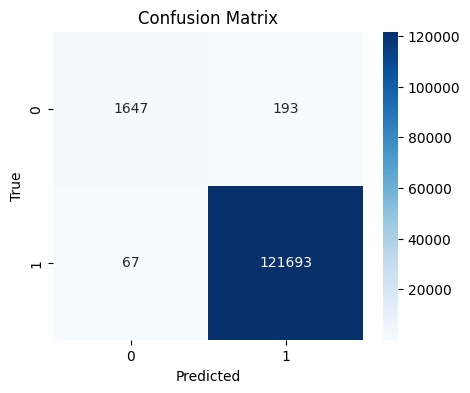

[分類報告]
              precision    recall  f1-score   support

      Benign       0.96      0.90      0.93      1840
        DDoS       1.00      1.00      1.00    121760

    accuracy                           1.00    123600
   macro avg       0.98      0.95      0.96    123600
weighted avg       1.00      1.00      1.00    123600



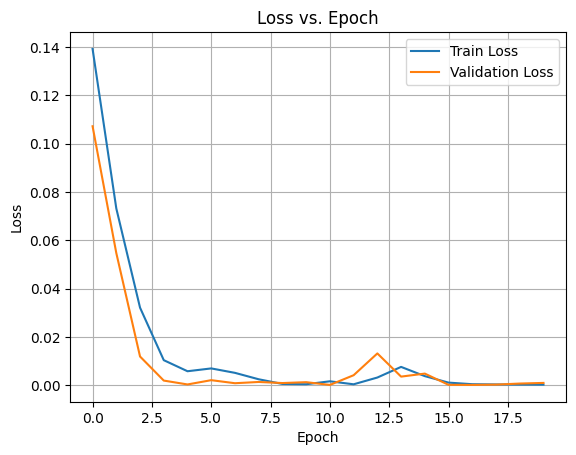

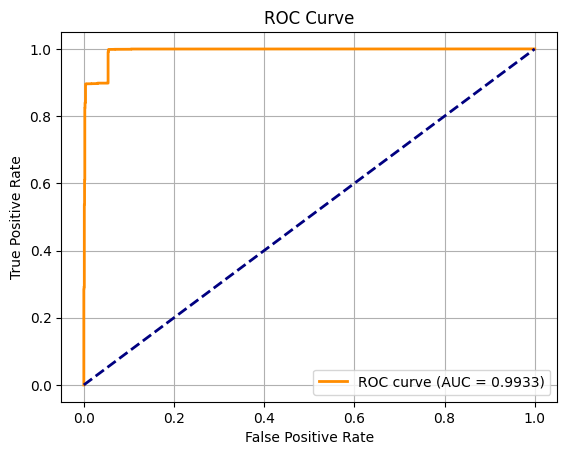

In [34]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# 混淆矩陣
cm = confusion_matrix(all_y_true, all_y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# 分類報告
print("[分類報告]")
print(classification_report(all_y_true, all_y_pred, target_names=["Benign", "DDoS"]))

# Loss vs. Epoch 曲線
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ROC 曲線
fpr, tpr, _ = roc_curve(all_y_true, all_y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


/var/folders/sq/hg8np8js4x92j1nx8y_mlls80000gn/T/ipykernel_87373/3597549909.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y="F1 Score", ax=axes[0, 0], palette="Set2")
/var/folders/sq/hg8np8js4x92j1nx8y_mlls80000gn/T/ipykernel_87373/3597549909.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y="Recall", ax=axes[0, 1], palette="Set2")
/var/folders/sq/hg8np8js4x92j1nx8y_mlls80000gn/T/ipykernel_87373/3597549909.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x="Model", y="Throughpu

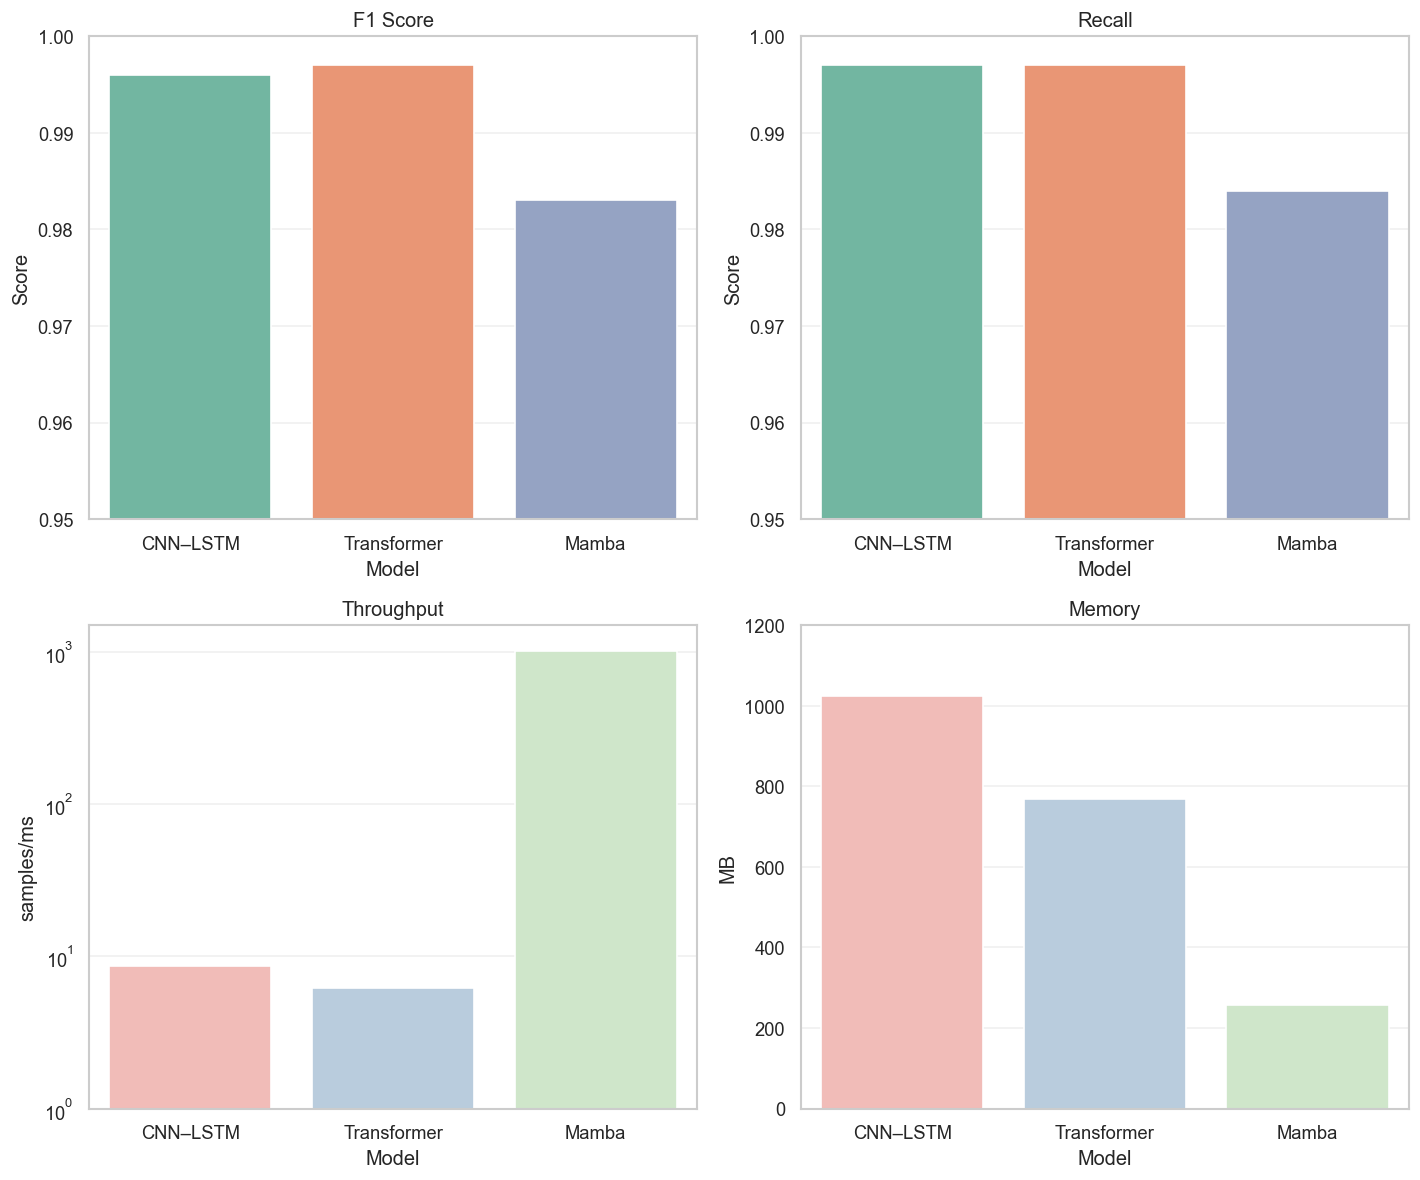

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 使用 seaborn 的美觀樣式
sns.set_theme(style="whitegrid")

# 模型資料
data = {
    "Model": ["CNN–LSTM", "Transformer", "Mamba"],
    "F1 Score": [0.996, 0.997, 0.983],
    "Recall": [0.997, 0.997, 0.984],
    "Throughput (samples/ms)": [8.7, 6.2, 1024],
    "Memory (MB)": [1024, 768, 256],
    "Estimated Latency (ms/batch)": [330, 462, 2.8]
}

df = pd.DataFrame(data)

# 建立圖表：2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 子圖 1：F1 Score (左上)
sns.barplot(data=df, x="Model", y="F1 Score", ax=axes[0, 0], palette="Set2")
axes[0, 0].set_title("F1 Score")
axes[0, 0].set_ylabel("Score")
axes[0, 0].set_ylim(0.95, 1.0)

# 子圖 2：Recall (右上)
sns.barplot(data=df, x="Model", y="Recall", ax=axes[0, 1], palette="Set2")
axes[0, 1].set_title("Recall")
axes[0, 1].set_ylabel("Score")
axes[0, 1].set_ylim(0.95, 1.0)

# 子圖 3：Throughput (左下)
sns.barplot(data=df, x="Model", y="Throughput (samples/ms)", ax=axes[1, 0], palette="Pastel1")
axes[1, 0].set_title("Throughput")
axes[1, 0].set_ylabel("samples/ms")
axes[1, 0].set_yscale("log")  # 使用對數刻度以顯示大範圍差異
axes[1, 0].set_ylim(1, 1500)

# 子圖 4：Memory (右下)
sns.barplot(data=df, x="Model", y="Memory (MB)", ax=axes[1, 1], palette="Pastel1")
axes[1, 1].set_title("Memory")
axes[1, 1].set_ylabel("MB")
axes[1, 1].set_ylim(0, 1200)

# 調整佈局
plt.tight_layout()
plt.show()

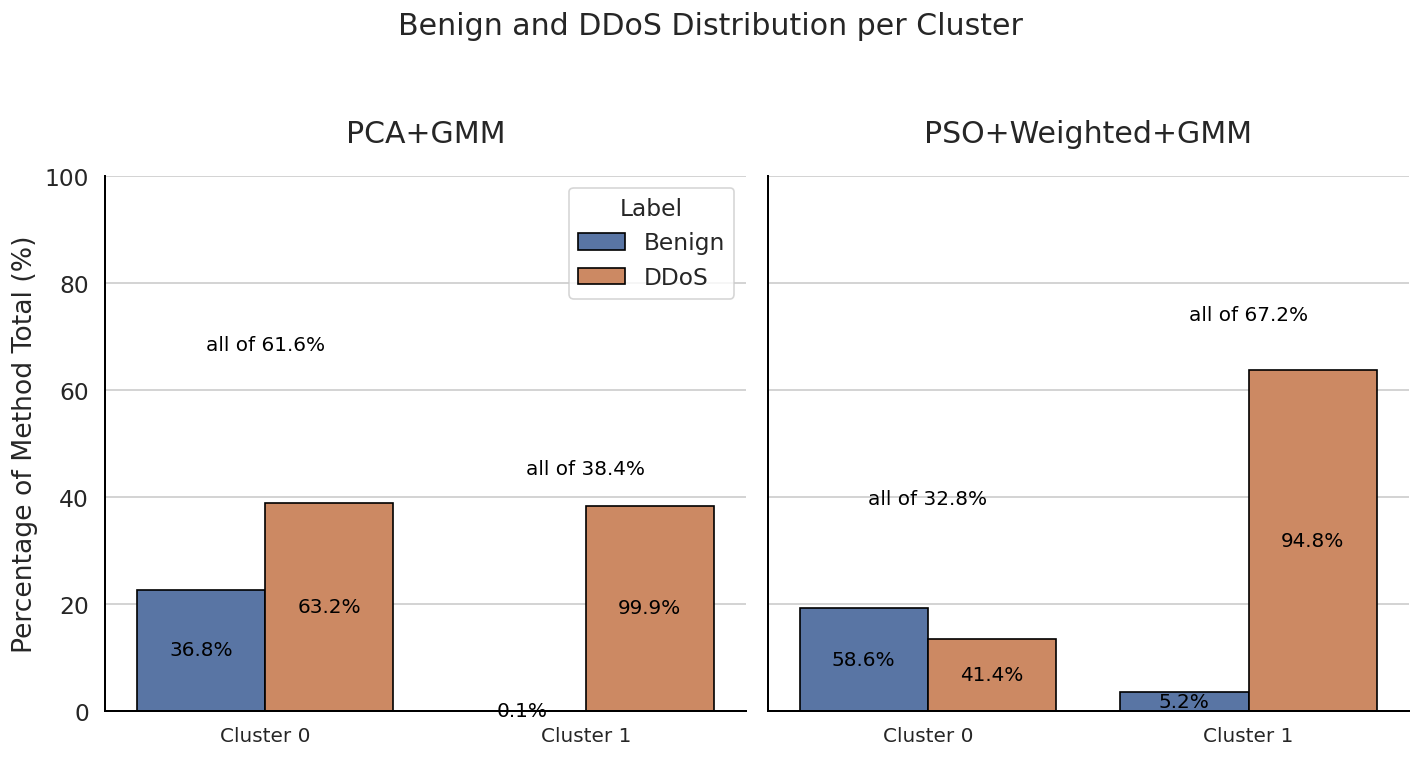

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 設定美化
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 14,
    "legend.fontsize": 14,
    "figure.dpi": 120,
    "font.family": "sans-serif",
    "font.sans-serif": ["DejaVu Sans"],
    "axes.edgecolor": "black",
    "axes.linewidth": 1.2
})

# 整理數據
data = [
    {"Method": "PCA+GMM", "Cluster": "Cluster 0", "Benign": 9066, "DDoS": 15566},
    {"Method": "PCA+GMM", "Cluster": "Cluster 1", "Benign": 8, "DDoS": 15360},
    {"Method": "PSO+Weighted+GMM", "Cluster": "Cluster 0", "Benign": 7676, "DDoS": 5432},
    {"Method": "PSO+Weighted+GMM", "Cluster": "Cluster 1", "Benign": 1398, "DDoS": 25494},
]

df = pd.DataFrame(data)
df["Total"] = df["Benign"] + df["DDoS"]
df["Group"] = df["Cluster"]  # Simplified for subplot, only show Cluster in x-axis

# 計算每個 Method 的總樣本數
method_totals = df.groupby("Method")["Total"].sum().to_dict()

# 轉長格式
df_melted = df.melt(id_vars=["Group", "Total", "Method"], value_vars=["Benign", "DDoS"],
                    var_name="Label", value_name="Count")

# 計算百分比（相對於每個 Method 的總數）
df_melted["Percent_in_Cluster"] = df_melted["Count"] / df_melted["Total"] * 100
df_melted["Count_as_Percent"] = df_melted.apply(
    lambda row: (row["Count"] / method_totals[row["Method"]] * 100), axis=1
)

# 畫圖：分成兩個子圖
palette = {"Benign": "#4C72B0", "DDoS": "#DD8452"}

# 創建子圖
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# 子圖 1: PCA+GMM
df_pca = df_melted[df_melted["Method"] == "PCA+GMM"]
sns.barplot(
    data=df_pca,
    x="Group", y="Count_as_Percent", hue="Label",
    palette=palette, edgecolor="black", ax=ax1
)
ax1.set_title("PCA+GMM", pad=20)
ax1.set_ylabel("Percentage of Method Total (%)")
ax1.set_xlabel("")
ax1.set_ylim(0, 100)
ax1.legend(title="Label", title_fontsize=14)

# 在柱子中間標百分比（In-cluster ratio）
for container, label in zip(ax1.containers, ["Benign", "DDoS"]):
    for i, bar in enumerate(container):
        height = bar.get_height()
        if height > 0:
            percent = df_pca[df_pca["Label"] == label]["Percent_in_Cluster"].iloc[i]
            if percent > 0:
                ax1.text(
                    bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + height/2, 
                    f"{percent:.1f}%",
                    ha="center", va="center", color="black", fontsize=12
                )

# 在整根上面標總佔比
group_total_pca = df[df["Method"] == "PCA+GMM"].groupby(["Group", "Method"])["Total"].sum().reset_index()
group_total_pca["Total_Percent"] = group_total_pca.apply(
    lambda row: (row["Total"] / method_totals[row["Method"]] * 100), axis=1
)
for idx, row in group_total_pca.iterrows():
    max_height = df_pca[df_pca["Group"] == row["Group"]]["Count_as_Percent"].sum()
    annotation_y = min(max_height + 5, 90)
    ax1.text(
        idx, annotation_y,
        f"all of {row['Total_Percent']:.1f}%",
        ha="center", va="bottom", fontsize=12, color="black"
    )

# 子圖 2: PSO+Weighted+GMM
df_pso = df_melted[df_melted["Method"] == "PSO+Weighted+GMM"]
sns.barplot(
    data=df_pso,
    x="Group", y="Count_as_Percent", hue="Label",
    palette=palette, edgecolor="black", ax=ax2
)
ax2.set_title("PSO+Weighted+GMM", pad=20)
ax2.set_ylabel("")
ax2.set_xlabel("")
ax2.set_ylim(0, 100)
ax2.legend().set_visible(False)  # 移除重複的圖例

# 在柱子中間標百分比（In-cluster ratio）
for container, label in zip(ax2.containers, ["Benign", "DDoS"]):
    for i, bar in enumerate(container):
        height = bar.get_height()
        if height > 0:
            percent = df_pso[df_pso["Label"] == label]["Percent_in_Cluster"].iloc[i]
            if percent > 0:
                ax2.text(
                    bar.get_x() + bar.get_width()/2, 
                    bar.get_y() + height/2, 
                    f"{percent:.1f}%",
                    ha="center", va="center", color="black", fontsize=12
                )

# 在整根上面標總佔比
group_total_pso = df[df["Method"] == "PSO+Weighted+GMM"].groupby(["Group", "Method"])["Total"].sum().reset_index()
group_total_pso["Total_Percent"] = group_total_pso.apply(
    lambda row: (row["Total"] / method_totals[row["Method"]] * 100), axis=1
)
for idx, row in group_total_pso.iterrows():
    max_height = df_pso[df_pso["Group"] == row["Group"]]["Count_as_Percent"].sum()
    annotation_y = min(max_height + 5, 90)
    ax2.text(
        idx, annotation_y,
        f"all of {row['Total_Percent']:.1f}%",
        ha="center", va="bottom", fontsize=12, color="black"
    )

# 調整細節
fig.suptitle("Benign and DDoS Distribution per Cluster", fontsize=18, y=1.05)
plt.tight_layout()
sns.despine()
plt.show()